In [51]:
import pandas as pd
import numpy as np
import pyhubs
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from matplotlib import pyplot as plt

In [52]:
trainLabels = pd.read_csv("typing-challenge/task2/task2-keystrokes-12users-train-labels.txt", header=None)
trainLabels.columns = ["record_id","user_id_train"]
trainLabels.shape
n_neigh = 7

In [53]:
trueLabels = pd.read_csv("typing-challenge/task2/sol/true_labels.csv", header=None)
trueLabels.columns = ["record_id","usedInTest", "record_id_true"]
trueLabels = trueLabels.loc[trueLabels.usedInTest == 1]
trueLabels

,record_id,usedInTest,record_id_true
0,0,1,1
1,1,1,9
2,2,1,5
5,5,1,5
7,9,1,3
...,...,...,...
474,534,1,1
479,539,1,6
483,543,1,4
485,545,1,8


In [54]:
valLabels = pd.read_csv("typing-challenge/task2/sol/true_labels.csv", header=None)
valLabels.columns = ["record_id","usedInTest", "record_id_true"]
valLabels = valLabels.loc[valLabels.usedInTest == 0]
valLabels

,record_id,usedInTest,record_id_true
3,3,0,6
4,4,0,10
6,6,0,8
8,10,0,11
9,11,0,2
...,...,...,...
480,540,0,7
481,541,0,6
482,542,0,8
484,544,0,6


In [55]:
def process_knn(addr,featureAddress, trainLabels, trueLabels, n_neigh, n_neigh_fit, meanSub, emptySub, storeSolution=False):

    df = pd.DataFrame(np.load(addr+featureAddress))
    df.index = df.index-1
    if meanSub:
        df = df-df.iloc[0,:] # removing empty image
    if emptySub:
        df = df-df.mean(axis=0) # removing mean image
    dfY = df.join(trainLabels.set_index("record_id"),how="inner")
    
    from sklearn.neighbors import KNeighborsClassifier
    neigh = pyhubs.HWKNN(k_fit=n_neigh_fit,k_pred=n_neigh, metric=pyhubs.cosDistance)
    neigh.fit(dfY.iloc[:,:-1].values,dfY.iloc[:,-1:]["user_id_train"].values)
    #res = neigh.predict(df)
    resDF = pd.DataFrame(neigh.predict(df.values))
    resDF.index = resDF.index-1 #Empty file is here as well
    resDF.columns = ["record_id_predicted"]
    resDF.record_id_predicted = resDF.record_id_predicted.astype(int)
        
    jointDF = resDF
    jointDF = jointDF.join(trueLabels.set_index("record_id"), how="inner")

    evalRes = (jointDF.record_id_predicted == jointDF.record_id_true).sum() / (jointDF.record_id_predicted == jointDF.record_id_true).count()
    print(evalRes, featureAddress, n_neigh, meanSub, emptySub)
    if storeSolution:
        fname = featureAddress.replace(".npy","")
        faddr = addr.replace("visualizations_task2_extracted/task2_visualizations2_","").replace("/","")
        rStore = resDF["record_id_predicted"]
        rStore = rStore.iloc[1:]        
        rStore.to_csv("task2_HWkNN_"+faddr+"_"+fname+"_"+str(n_neigh)+"_"+str(n_neigh_fit)+"_"+str(meanSub)+"_"+str(emptySub)+".csv", header=False)
  
    return evalRes

In [56]:
from os import listdir
from os.path import isfile, join
def process_source():
    addr_base = "visualizations_task2_extracted/task2_visualizations2_"
    res = []
    for addr_ext in ["extracted/","inverted_extracted/","inverted2_extracted/","inverted3_extracted/","blacks_extracted/"]:
        addr = addr_base + addr_ext 
        onlyfiles = [f for f in listdir(addr) if isfile(join(addr, f))]

        for n_neigh in [1,3,5,7]:
            for n_neigh_fit in [3,5]:
                for meanSub in [True]:
                    for emptySub in [False]:
                        for f in onlyfiles:    
                            evalRes = process_knn(addr, f, trainLabels, valLabels, n_neigh, n_neigh_fit,meanSub, emptySub)
                            res.append([f,n_neigh, n_neigh_fit, meanSub, emptySub, evalRes, addr_ext])
                            
    resDF = pd.DataFrame(res)
    resDF.columns = ["feature_set","n_neigh","n_neigh_fit","meanSub","emptySub","results","data"]
    #resDF.sort_values("results").tail(50)  
    return resDF

In [57]:
df = process_source()

0.4166666666666667 EfficientNetExtractor_2_.npy 1 True False
0.5833333333333334 ImageGPTExtractor_medium_.npy 1 True False
0.7301587301587301 RGBHistogramExtractorGrid_256_1.npy 1 True False
0.3968253968253968 RGBHistogramExtractorGrid_256_2.npy 1 True False
0.7222222222222222 RGBHistogramExtractorGrid_32_1.npy 1 True False
0.43253968253968256 RGBHistogramExtractorGrid_32_2.npy 1 True False
0.7222222222222222 RGBHistogramExtractorGrid_64_1.npy 1 True False
0.4087301587301587 RGBHistogramExtractorGrid_64_2.npy 1 True False
0.6626984126984127 RGBHistogramExtractor_256_.npy 1 True False
0.6785714285714286 RGBHistogramExtractor_64_.npy 1 True False
0.5753968253968254 ViTExtractor_large_.npy 1 True False
0.5476190476190477 VLADExctractor__.npy 1 True False
0.4166666666666667 EfficientNetExtractor_2_.npy 1 True False
0.5833333333333334 ImageGPTExtractor_medium_.npy 1 True False
0.7301587301587301 RGBHistogramExtractorGrid_256_1.npy 1 True False
0.3968253968253968 RGBHistogramExtractorGrid_25

0.7103174603174603 RGBHistogramExtractor_64_.npy 3 True False
0.5158730158730159 ViTExtractor_large_.npy 3 True False
0.5595238095238095 VLADExctractor__.npy 3 True False
0.47619047619047616 EfficientNetExtractor_2_.npy 3 True False
0.5634920634920635 ImageGPTExtractor_medium_.npy 3 True False
0.6865079365079365 RGBHistogramExtractorGrid_256_1.npy 3 True False
0.38492063492063494 RGBHistogramExtractorGrid_256_2.npy 3 True False
0.7698412698412699 RGBHistogramExtractorGrid_32_1.npy 3 True False
0.373015873015873 RGBHistogramExtractorGrid_32_2.npy 3 True False
0.7658730158730159 RGBHistogramExtractorGrid_64_1.npy 3 True False
0.36904761904761907 RGBHistogramExtractorGrid_64_2.npy 3 True False
0.7222222222222222 RGBHistogramExtractor_256_.npy 3 True False
0.7341269841269841 RGBHistogramExtractor_64_.npy 3 True False
0.44841269841269843 ViTExtractor_large_.npy 3 True False
0.5634920634920635 VLADExctractor__.npy 3 True False
0.47619047619047616 EfficientNetExtractor_2_.npy 5 True False
0.5

0.6706349206349206 RGBHistogramExtractorGrid_256_1.npy 5 True False
0.3333333333333333 RGBHistogramExtractorGrid_256_2.npy 5 True False
0.6746031746031746 RGBHistogramExtractorGrid_32_1.npy 5 True False
0.3611111111111111 RGBHistogramExtractorGrid_32_2.npy 5 True False
0.6904761904761905 RGBHistogramExtractorGrid_64_1.npy 5 True False
0.34523809523809523 RGBHistogramExtractorGrid_64_2.npy 5 True False
0.2777777777777778 RGBHistogramExtractorGrid_64_3.npy 5 True False
0.6706349206349206 RGBHistogramExtractor_256_.npy 5 True False
0.6626984126984127 RGBHistogramExtractor_64_.npy 5 True False
0.49603174603174605 ViTExtractor_large_.npy 5 True False
0.5396825396825397 VLADExctractor__.npy 5 True False
0.4166666666666667 EfficientNetExtractor_2_.npy 7 True False
0.49206349206349204 ImageGPTExtractor_medium_.npy 7 True False
0.6547619047619048 RGBHistogramExtractorGrid_256_1.npy 7 True False
0.3134920634920635 RGBHistogramExtractorGrid_256_2.npy 7 True False
0.623015873015873 RGBHistogramExt

0.6428571428571429 RGBHistogramExtractor_256_.npy 7 True False
0.6666666666666666 RGBHistogramExtractor_64_.npy 7 True False
0.43253968253968256 ViTExtractor_large_.npy 7 True False
0.6111111111111112 VLADExctractor__.npy 7 True False
0.4603174603174603 EfficientNetExtractor_2_.npy 1 True False
0.6190476190476191 ImageGPTExtractor_medium_.npy 1 True False
0.5158730158730159 RGBHistogramExtractorGrid_256_1.npy 1 True False
0.3134920634920635 RGBHistogramExtractorGrid_256_2.npy 1 True False
0.5793650793650794 RGBHistogramExtractorGrid_32_1.npy 1 True False
0.3492063492063492 RGBHistogramExtractorGrid_32_2.npy 1 True False
0.5595238095238095 RGBHistogramExtractorGrid_64_1.npy 1 True False
0.32936507936507936 RGBHistogramExtractorGrid_64_2.npy 1 True False
0.5555555555555556 RGBHistogramExtractor_256_.npy 1 True False
0.5555555555555556 RGBHistogramExtractor_64_.npy 1 True False
0.5198412698412699 ViTExtractor_large_.npy 1 True False
0.5396825396825397 VLADExctractor__.npy 1 True False
0.4

In [58]:
df.sort_values("results").tail(50) 

,feature_set,n_neigh,n_neigh_fit,meanSub,emptySub,results,data
30,RGBHistogramExtractorGrid_64_1.npy,3,3,True,False,0.714286,extracted/
126,RGBHistogramExtractorGrid_64_1.npy,3,3,True,False,0.714286,inverted_extracted/
316,RGBHistogramExtractor_256_.npy,1,5,True,False,0.714286,inverted3_extracted/
196,RGBHistogramExtractorGrid_32_1.npy,1,3,True,False,0.714286,inverted2_extracted/
358,RGBHistogramExtractorGrid_256_1.npy,5,5,True,False,0.718254,inverted3_extracted/
305,RGBHistogramExtractor_64_.npy,1,3,True,False,0.718254,inverted3_extracted/
317,RGBHistogramExtractor_64_.npy,1,5,True,False,0.718254,inverted3_extracted/
18,RGBHistogramExtractorGrid_64_1.npy,1,5,True,False,0.722222,extracted/
44,RGBHistogramExtractor_256_.npy,3,5,True,False,0.722222,extracted/
16,RGBHistogramExtractorGrid_32_1.npy,1,5,True,False,0.722222,extracted/


In [59]:
df["algorithm"] = df["feature_set"]
df.loc[df["feature_set"].str.startswith("RGBHistogramExtractorGrid"),"algorithm"] = "RGBHistogram"
df.loc[df["feature_set"].str.startswith("RGBHistogramExtractor_"),"algorithm"] = "RGBHistogramExtractor_old"
df.loc[df["feature_set"].str.startswith("ImageGPTExtractor_medium_"),"algorithm"] = "ImageGPT"
df.loc[df["feature_set"].str.startswith("EfficientNetExtractor_2_"),"algorithm"] = "EfficientNet"
df.loc[df["feature_set"].str.startswith("ViTExtractor_large_"),"algorithm"] = "ViT"
df.loc[df["feature_set"].str.startswith("VLADExctractor__"),"algorithm"] = "VLAD"

df["data_fin"] = df["data"]
df.loc[df["data"].str.startswith("blacks_extracted"),"data_fin"] = "monochromatic"
df.loc[df["data"].str.startswith("extracted"),"data_fin"] = "RGB"
df.loc[df["data"].str.startswith("inverted2_extracted"),"data_fin"] = "RGB inverted"
df.loc[df["data"].str.startswith("inverted3_extracted"),"data_fin"] = "RG"
df.loc[df["data"].str.startswith("inverted_extracted"),"data_fin"] = "GBR"



df = df.loc[df["algorithm"] != "RGBHistogramExtractor_old"]

df

,feature_set,n_neigh,n_neigh_fit,meanSub,emptySub,results,data,algorithm,data_fin
0,EfficientNetExtractor_2_.npy,1,3,True,False,0.416667,extracted/,EfficientNet,RGB
1,ImageGPTExtractor_medium_.npy,1,3,True,False,0.583333,extracted/,ImageGPT,RGB
2,RGBHistogramExtractorGrid_256_1.npy,1,3,True,False,0.730159,extracted/,RGBHistogram,RGB
3,RGBHistogramExtractorGrid_256_2.npy,1,3,True,False,0.396825,extracted/,RGBHistogram,RGB
4,RGBHistogramExtractorGrid_32_1.npy,1,3,True,False,0.722222,extracted/,RGBHistogram,RGB
...,...,...,...,...,...,...,...,...,...
481,RGBHistogramExtractorGrid_32_2.npy,7,5,True,False,0.289683,blacks_extracted/,RGBHistogram,monochromatic
482,RGBHistogramExtractorGrid_64_1.npy,7,5,True,False,0.507937,blacks_extracted/,RGBHistogram,monochromatic
483,RGBHistogramExtractorGrid_64_2.npy,7,5,True,False,0.281746,blacks_extracted/,RGBHistogram,monochromatic
486,ViTExtractor_large_.npy,7,5,True,False,0.492063,blacks_extracted/,ViT,monochromatic


In [60]:
sortedD = df.sort_values('results')
sortedD = sortedD.drop_duplicates(["algorithm",'data'], keep='last')
sortedD

,feature_set,n_neigh,n_neigh_fit,meanSub,emptySub,results,data,algorithm,data_fin
283,EfficientNetExtractor_2_.npy,7,5,True,False,0.440476,inverted2_extracted/,EfficientNet,RGB inverted
48,EfficientNetExtractor_2_.npy,5,3,True,False,0.468254,extracted/,EfficientNet,RGB
368,EfficientNetExtractor_2_.npy,7,3,True,False,0.468254,inverted3_extracted/,EfficientNet,RG
132,EfficientNetExtractor_2_.npy,3,5,True,False,0.476190,inverted_extracted/,EfficientNet,GBR
416,EfficientNetExtractor_2_.npy,3,3,True,False,0.484127,blacks_extracted/,EfficientNet,monochromatic
216,ViTExtractor_large_.npy,1,5,True,False,0.519841,inverted2_extracted/,ViT,RGB inverted
154,ViTExtractor_large_.npy,5,3,True,False,0.527778,inverted_extracted/,ViT,GBR
438,ViTExtractor_large_.npy,3,5,True,False,0.543651,blacks_extracted/,ViT,monochromatic
306,ViTExtractor_large_.npy,1,3,True,False,0.543651,inverted3_extracted/,ViT,RG
295,VLADExctractor__.npy,7,5,True,False,0.547619,inverted2_extracted/,VLAD,RGB inverted


## Creating test solutions for the best evaluated models

In [64]:
addr_base = "visualizations_task2_extracted/task2_visualizations2_"
sortedD["final_res"] = 0.0
for i,row in sortedD.iterrows():
    #print(row[])
    r = process_knn(addr_base+row.loc["data"],row.loc["feature_set"], trainLabels, trueLabels, row.loc["n_neigh"], row.loc["n_neigh_fit"], True, False, True)
    sortedD.loc[i,"final_res"] = r

0.4279661016949153 EfficientNetExtractor_2_.npy 7 True False
0.4745762711864407 EfficientNetExtractor_2_.npy 5 True False
0.4279661016949153 EfficientNetExtractor_2_.npy 7 True False
0.5042372881355932 EfficientNetExtractor_2_.npy 3 True False
0.4788135593220339 EfficientNetExtractor_2_.npy 3 True False
0.5423728813559322 ViTExtractor_large_.npy 1 True False
0.4491525423728814 ViTExtractor_large_.npy 5 True False
0.5 ViTExtractor_large_.npy 3 True False
0.5423728813559322 ViTExtractor_large_.npy 1 True False
0.5847457627118644 VLADExctractor__.npy 7 True False
0.6398305084745762 VLADExctractor__.npy 5 True False
0.614406779661017 ViTExtractor_large_.npy 1 True False
0.690677966101695 ImageGPTExtractor_medium_.npy 1 True False
0.6016949152542372 ImageGPTExtractor_medium_.npy 1 True False
0.5677966101694916 VLADExctractor__.npy 5 True False
0.614406779661017 RGBHistogramExtractorGrid_32_1.npy 3 True False
0.6652542372881356 ImageGPTExtractor_medium_.npy 1 True False
0.6016949152542372 VL

In [65]:
tbl = pd.pivot_table(sortedD,values="final_res",columns="data_fin", index="algorithm")
tbl = tbl.reindex(["RGBHistogram","VLAD","EfficientNet","ViT","ImageGPT"])
tbl = tbl[["RG","RGB","RGB inverted","GBR","monochromatic"]]
tbl

data_fin,RG,RGB,RGB inverted,GBR,monochromatic
algorithm,,,,,
RGBHistogram,0.792373,0.762712,0.699153,0.762712,0.614407
VLAD,0.627119,0.601695,0.584746,0.639831,0.567797
EfficientNet,0.427966,0.474576,0.427966,0.504237,0.478814
ViT,0.542373,0.614407,0.542373,0.449153,0.500000
ImageGPT,0.601695,0.690678,0.665254,0.677966,0.572034


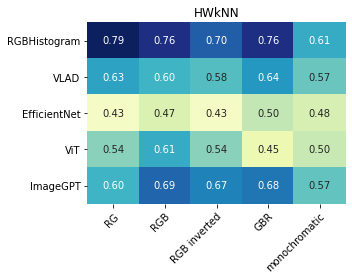

In [66]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(tbl,  cmap="YlGnBu", annot=True, fmt=".2f", vmin=0.40, vmax=0.80, cbar=False)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlabel("")
plt.ylabel("")
plt.title("HWkNN")
plt.tight_layout()

plt.savefig("hwknnResults.png",dpi=300)